In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap
from qiskit.algorithms.optimizers import SPSA, COBYLA

from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import TwoLocal

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


In [2]:
train_dataset = pd.read_csv('/Users/rishivarshilnelakurti/Documents/AP Research Project/higgs-boson/training.csv')
train_dataset.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [3]:
#constants

#seperating dataset into features & labels
features = train_dataset[['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']]

#MOD 1 low amount of qubits
num_qubits = 3

#features = features.to_numpy()
features = features.loc[0:100, :].to_numpy()



labels = train_dataset['Label']
#labels = labels.to_numpy()
labels = labels.loc[0:100].to_numpy()


#use PCA analysis to condese the number of features to 10
features = PCA(n_components=num_qubits).fit_transform(features)

#splitting dataset into train & test
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels,shuffle=False
)


In [4]:
#converting labels to -1 & 1
#
def convertlabels(labels):
    for x in np.nditer(labels,flags=["refs_ok"], op_flags=['readwrite']):
        if x == 's':
            x[...] = int(1)
        else:
            x[...] = int(0)
    return labels

train_labels = convertlabels(train_labels)
test_labels = convertlabels(test_labels)
print(train_labels)

[1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1
 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1
 0]


In [5]:
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:
from qiskit.utils import QuantumInstance, algorithm_globals, optionals
from qiskit_aer import Aer
objective_func_vals = []
#MOD 2 feature map
feature_map = ZFeatureMap(num_qubits, reps=1)
print(feature_map.decompose().draw())
#same optimizer to create the parameters
optimizer = COBYLA(maxiter=60) #MOD 3

#same parameterized circuit
two = TwoLocal(num_qubits, ['ry','rz'], 'cz', 'linear', reps=2, insert_barriers=True, skip_final_rotation_layer=True)
ansatz = QuantumCircuit(num_qubits)
ansatz += two

#provider = IBMQ.get_provider('ibm-q')
#sim = provider.backends.ibmq_qasm_simulator
#quantum_instance = QuantumInstance(sim, shots=1024)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=optimizer,
    callback=callback_graph
)

     ┌───┐┌─────────────┐
q_0: ┤ H ├┤ P(2.0*x[0]) ├
     ├───┤├─────────────┤
q_1: ┤ H ├┤ P(2.0*x[1]) ├
     ├───┤├─────────────┤
q_2: ┤ H ├┤ P(2.0*x[2]) ├
     └───┘└─────────────┘


/var/folders/j0/_gj6grj56hs061q_w_cvp4bw0000gp/T/ipykernel_35221/1777801011.py:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  ansatz += two


/Users/rishivarshilnelakurti/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


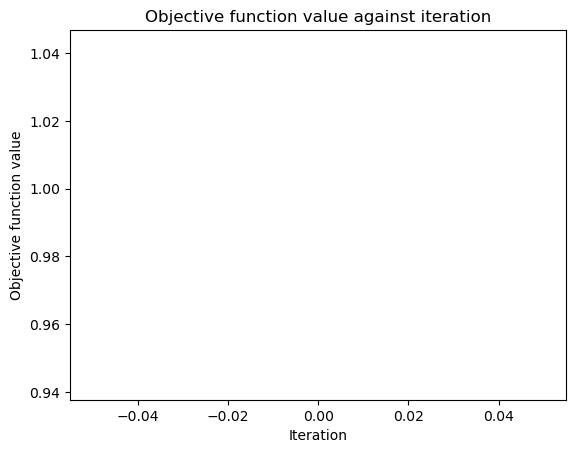

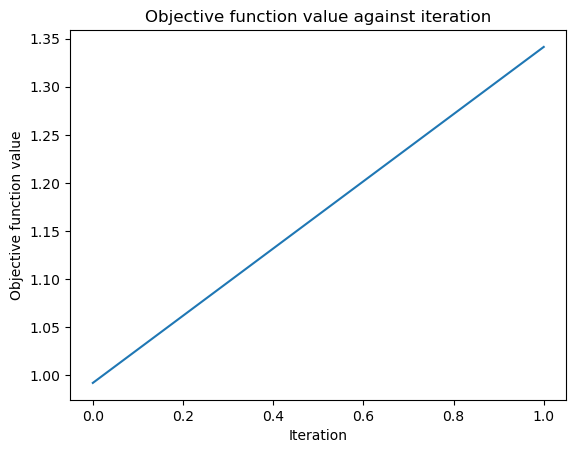

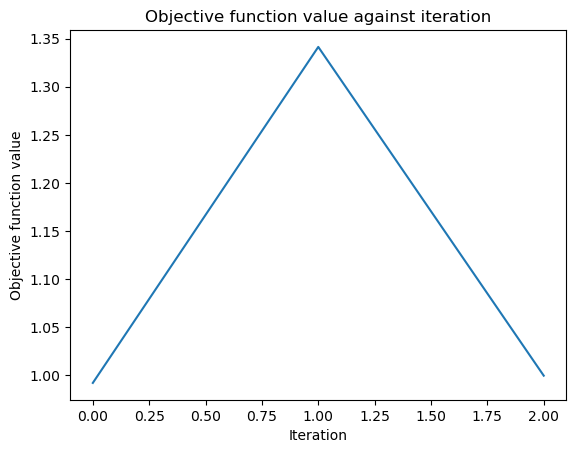

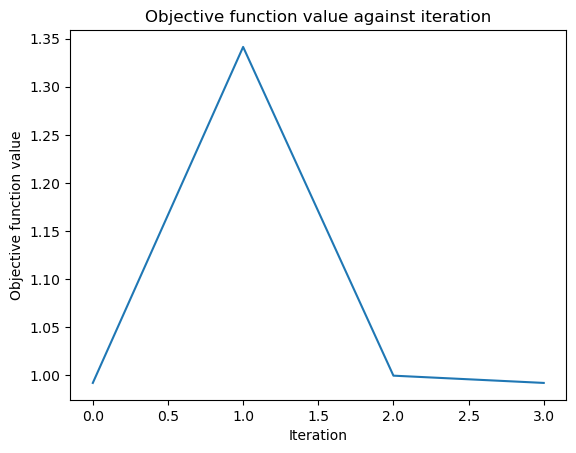

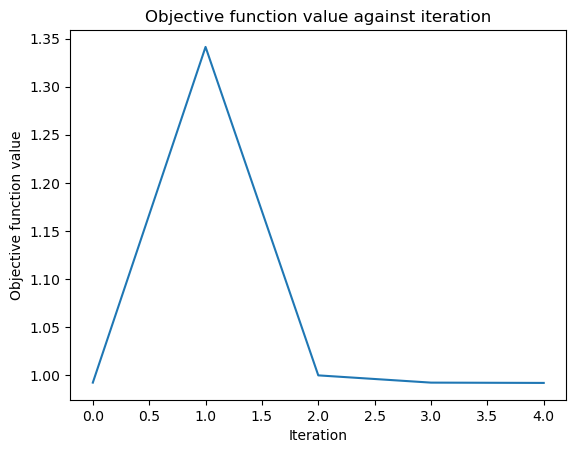

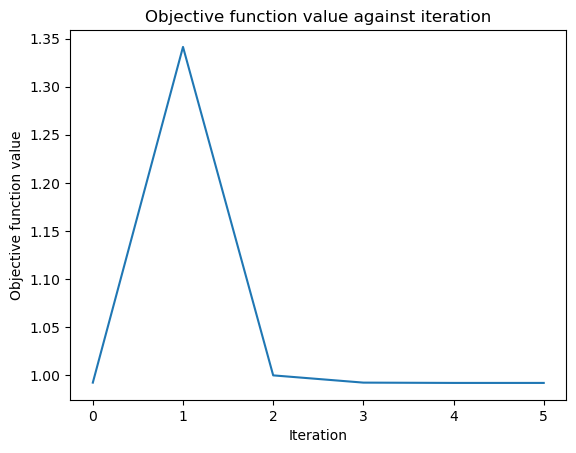

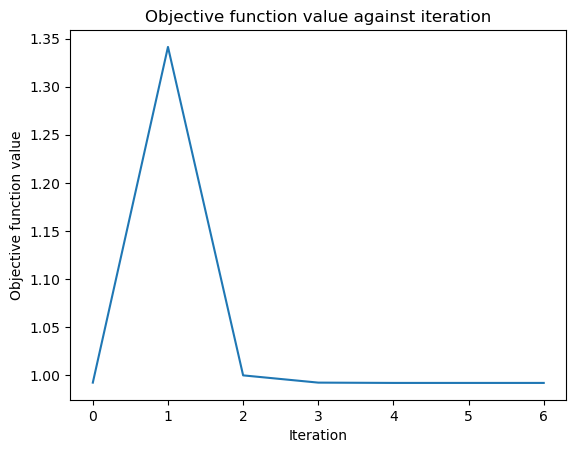

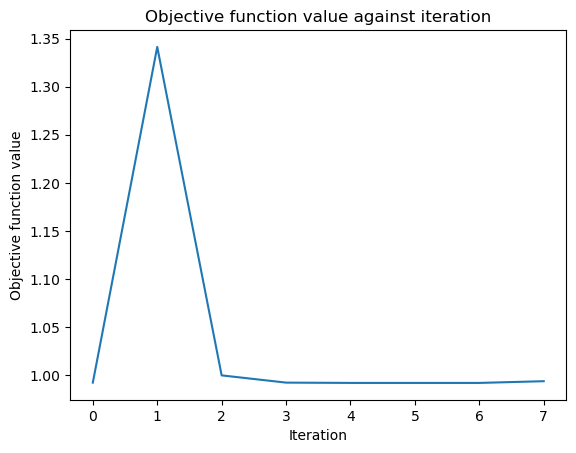

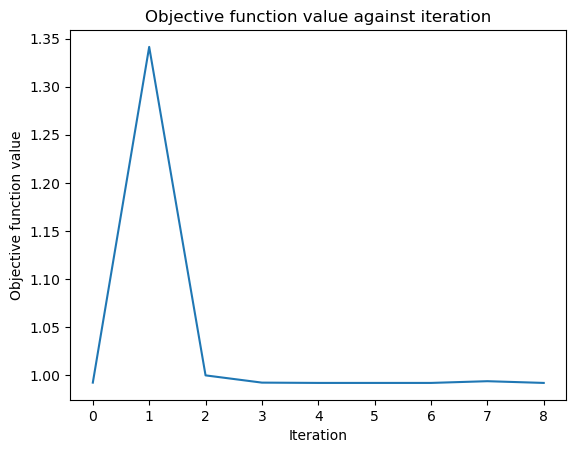

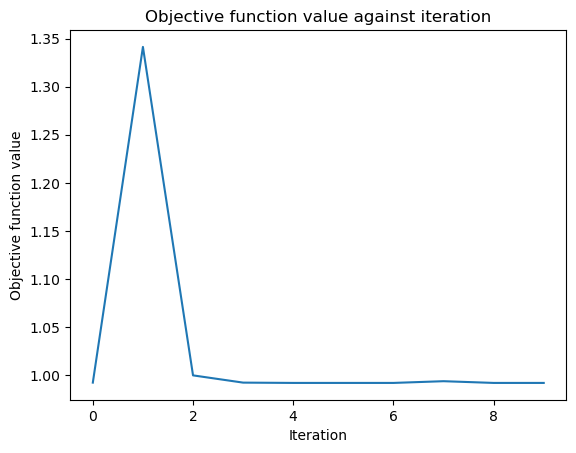

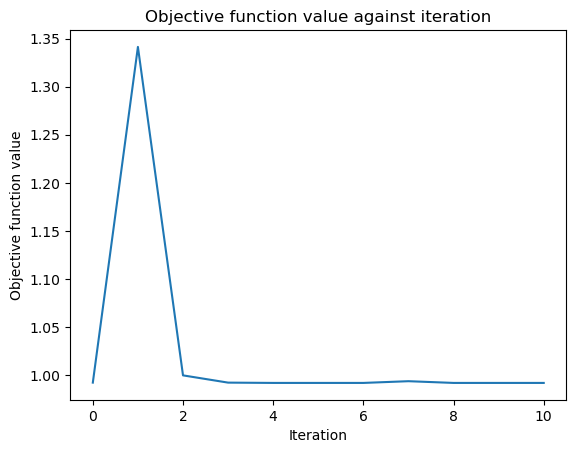

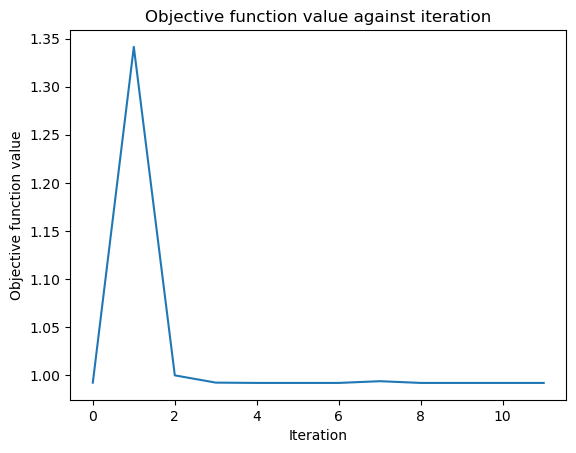

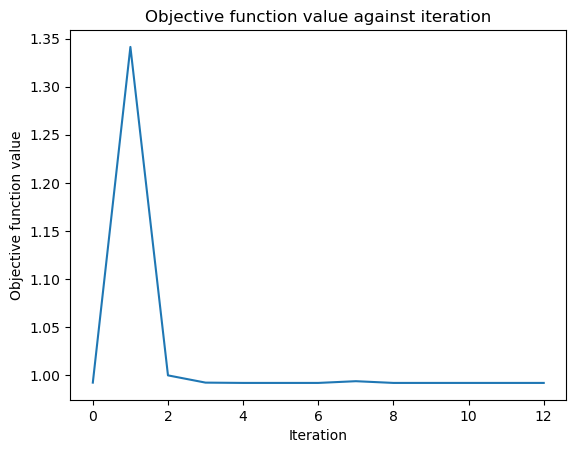

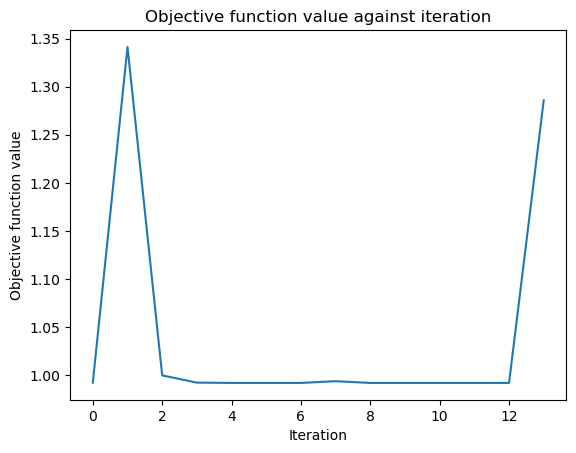

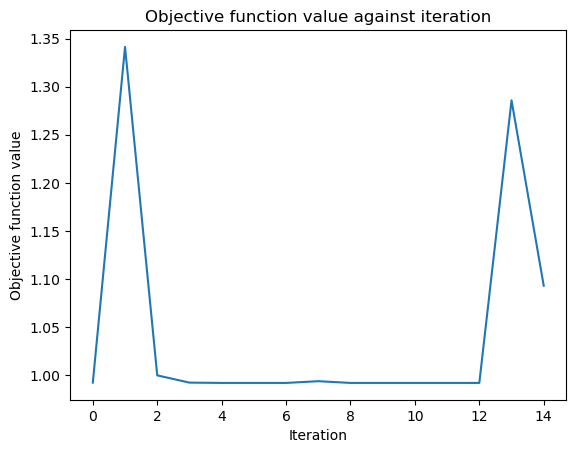

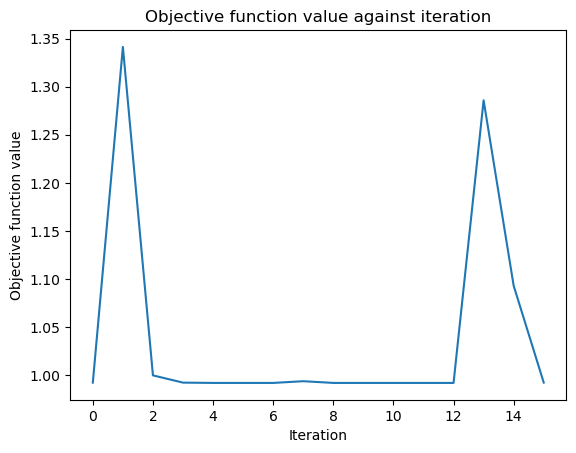

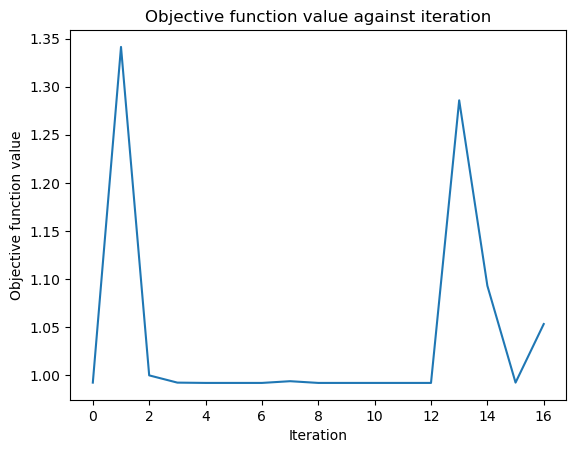

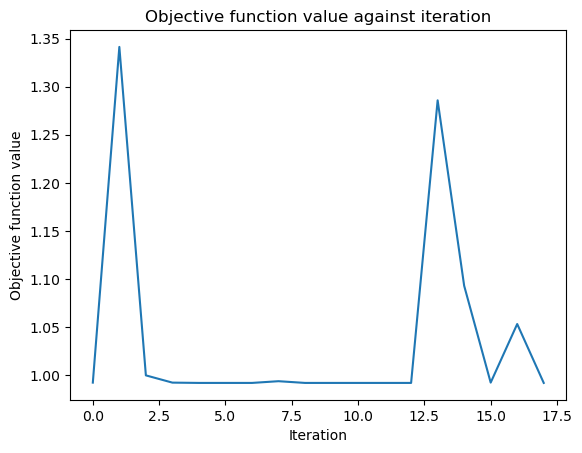

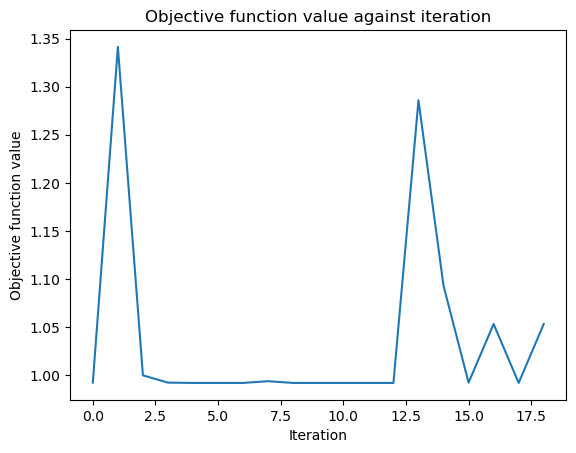

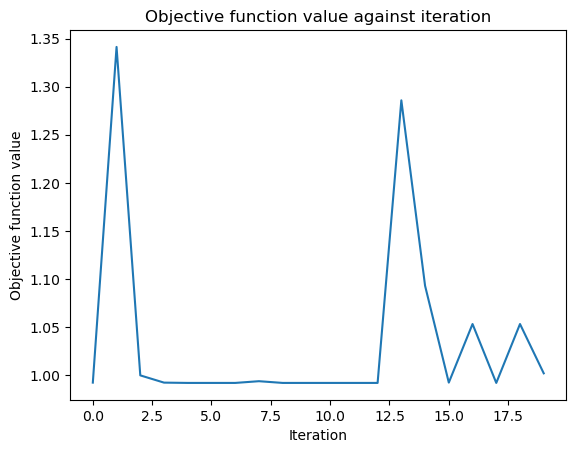

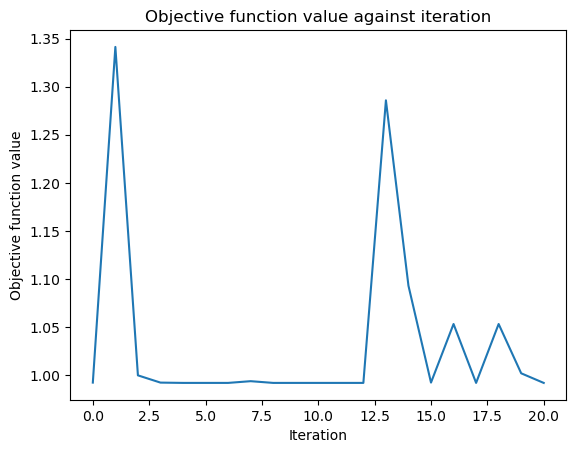

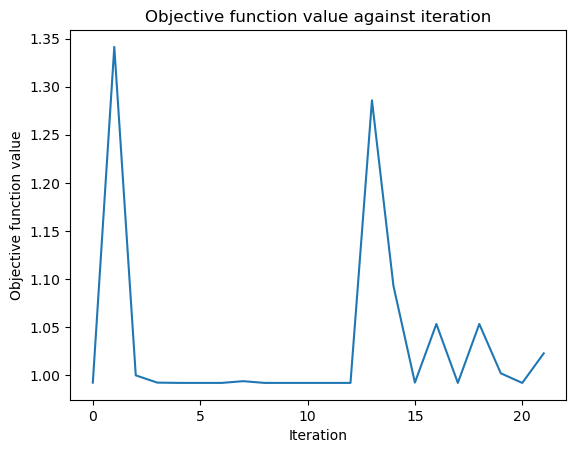

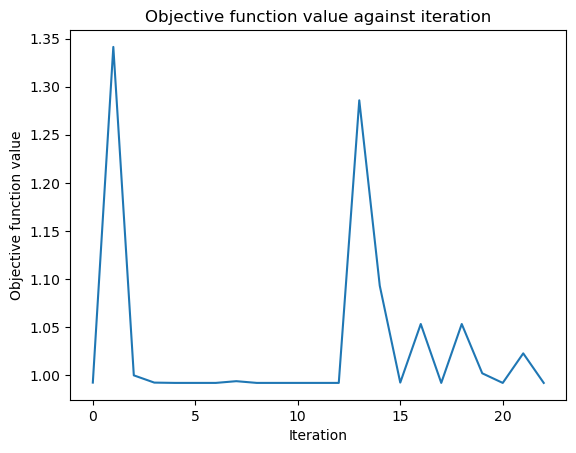

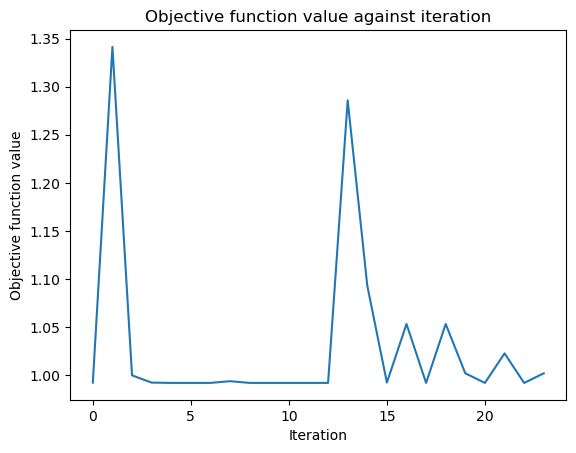

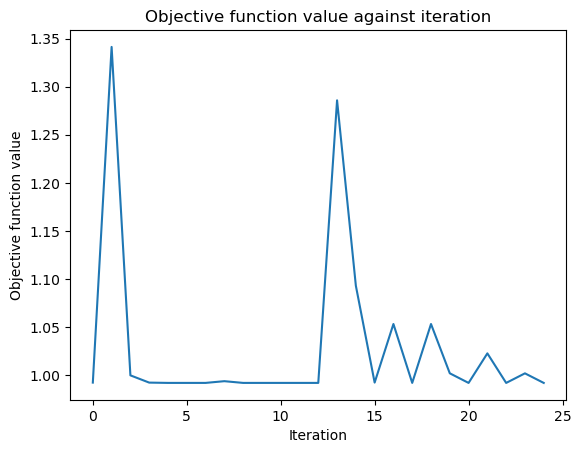

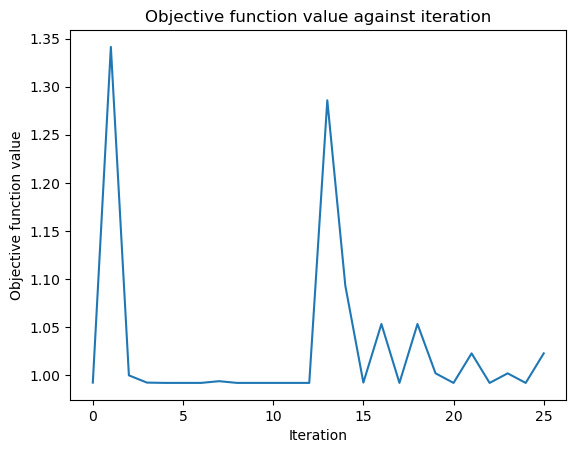

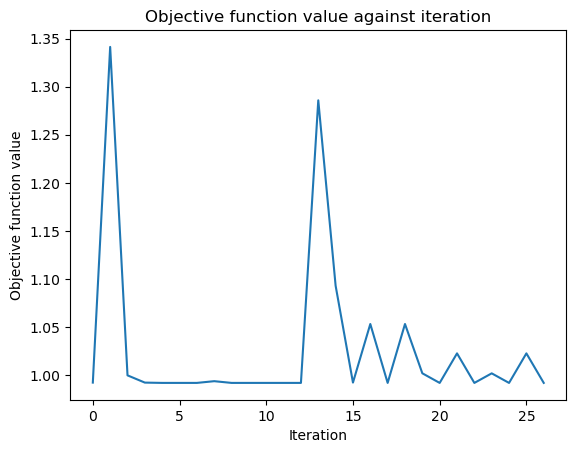

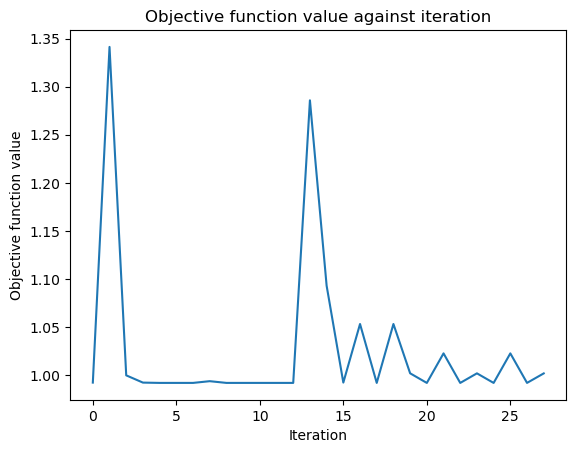

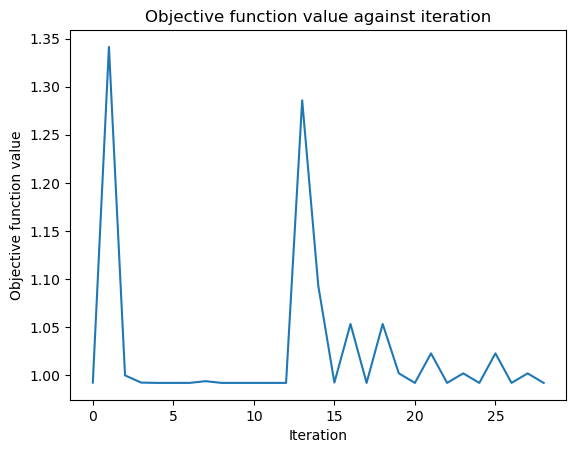

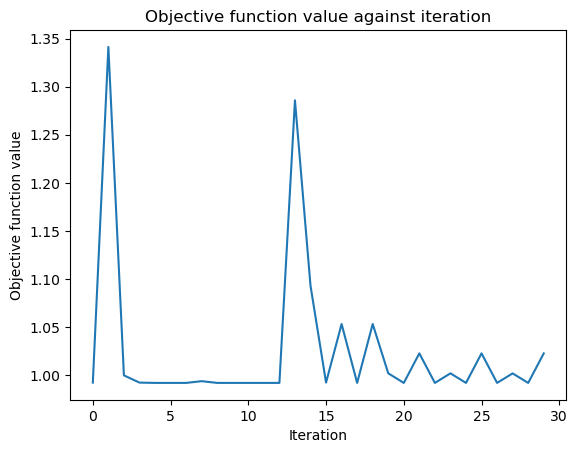

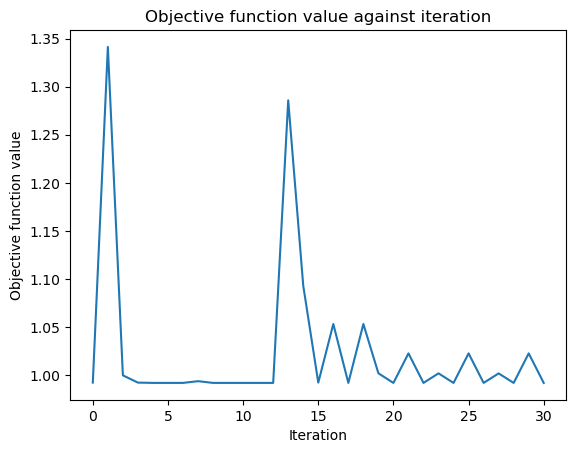

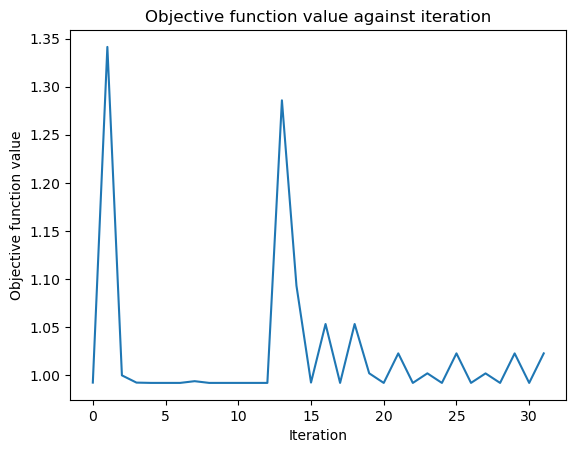

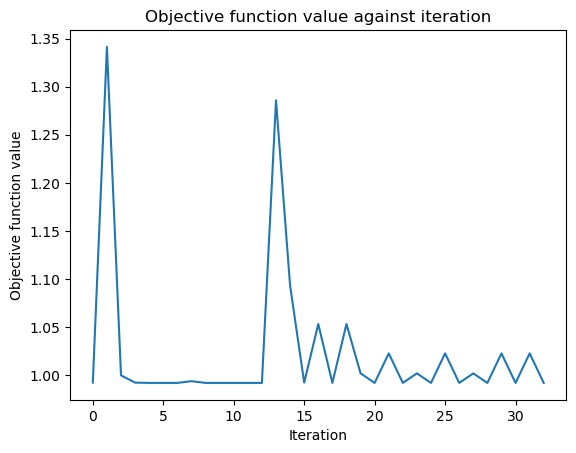

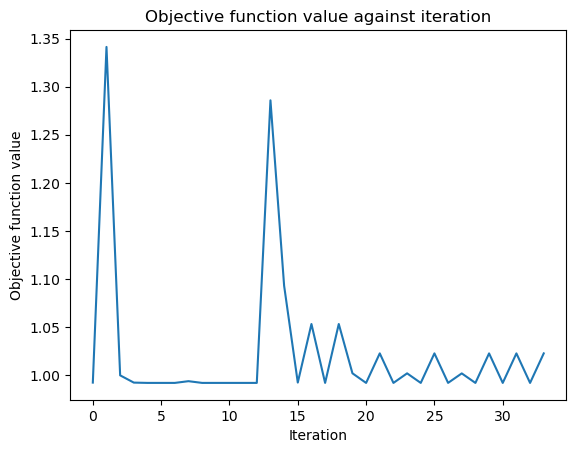

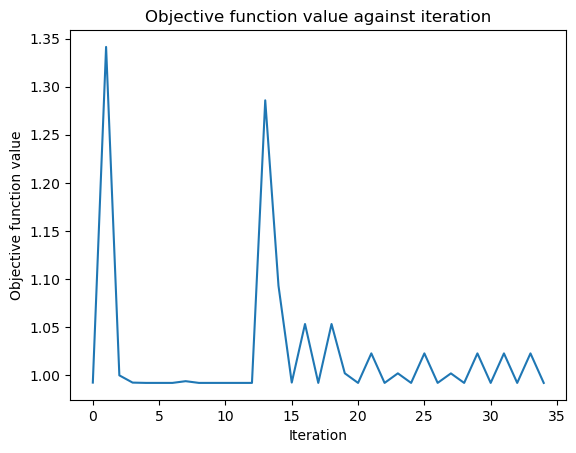

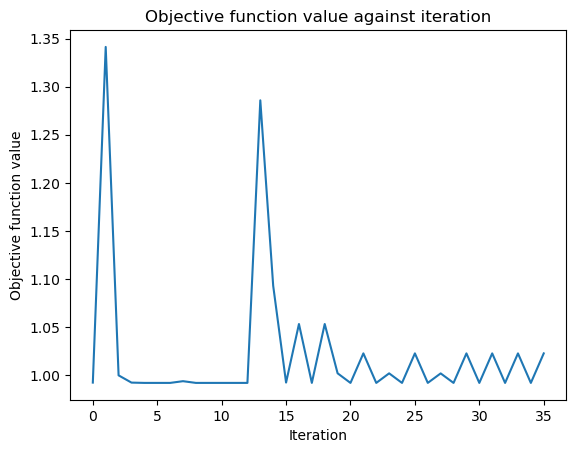

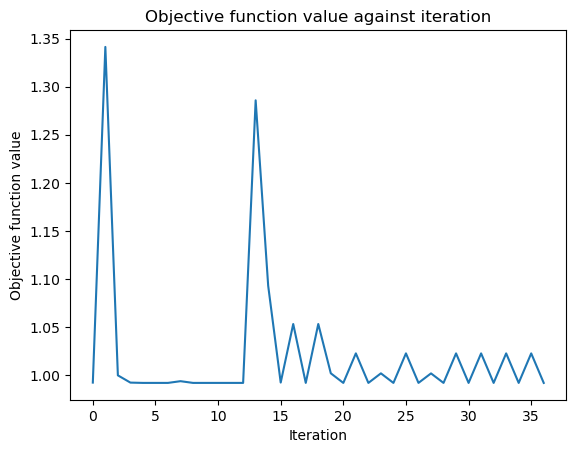

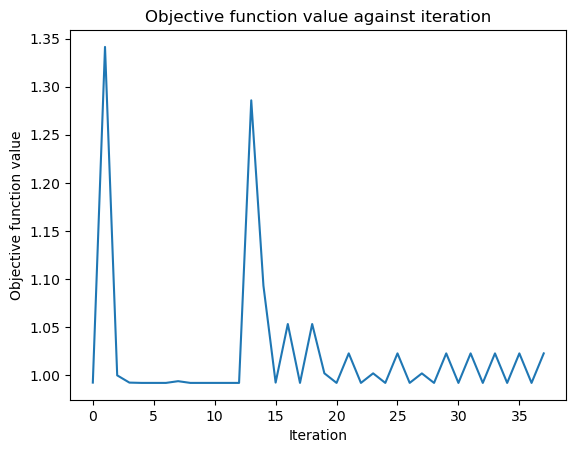

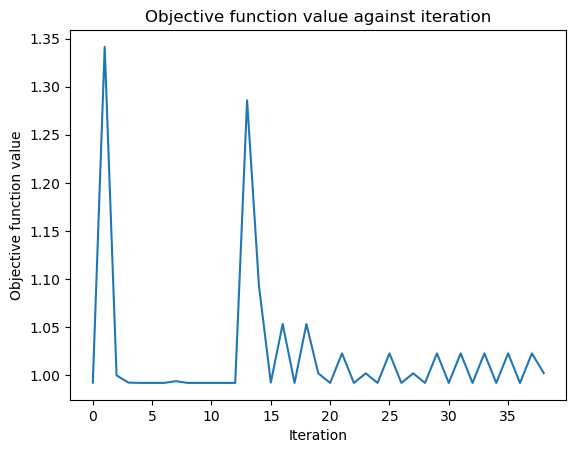

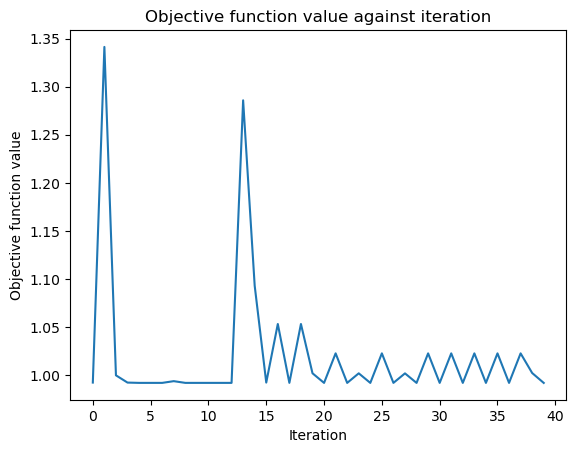

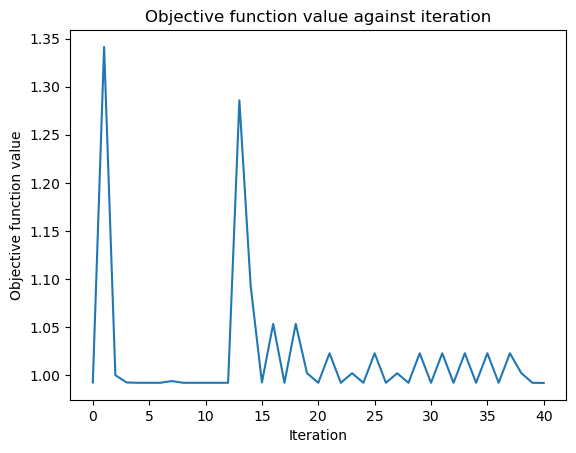

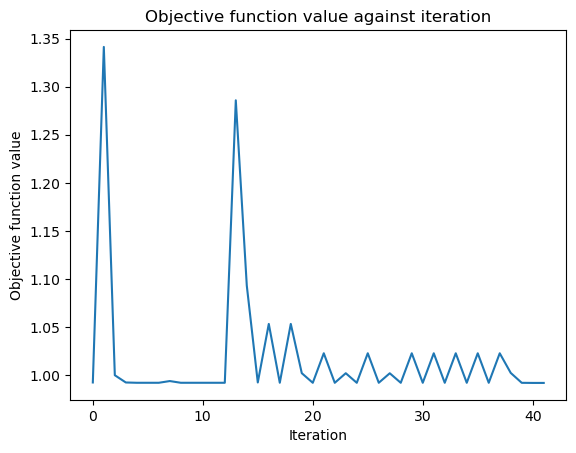

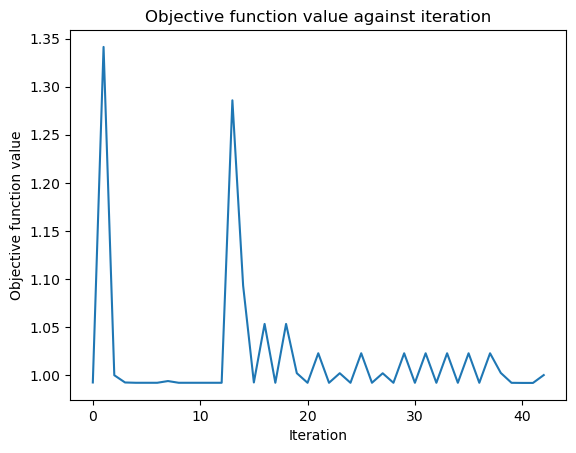

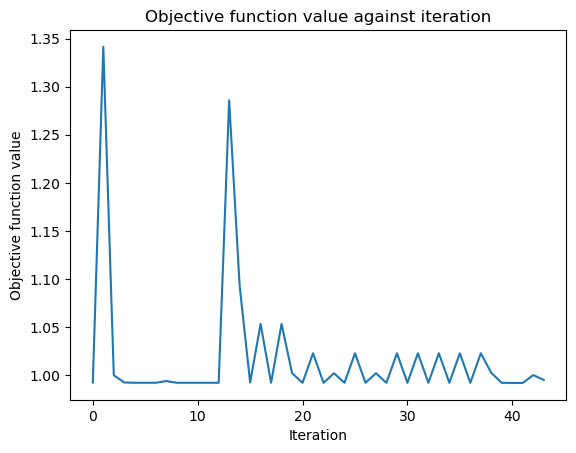

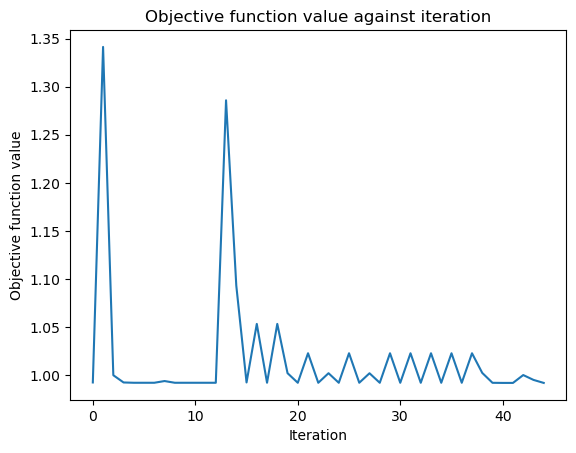

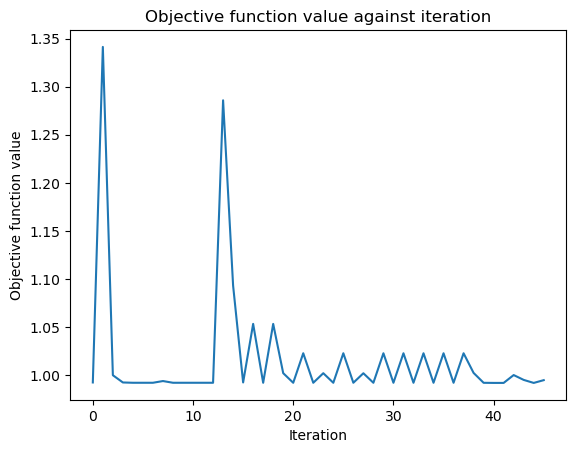

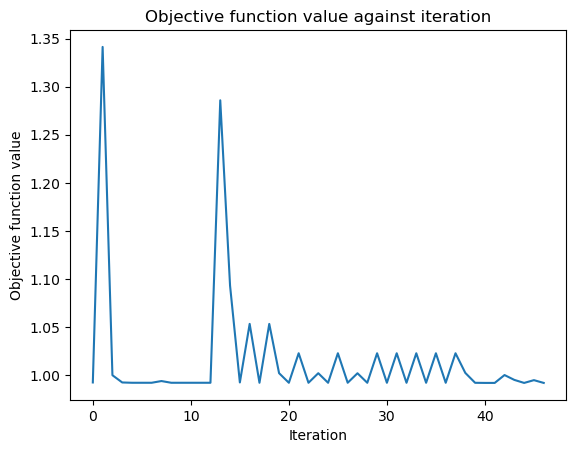

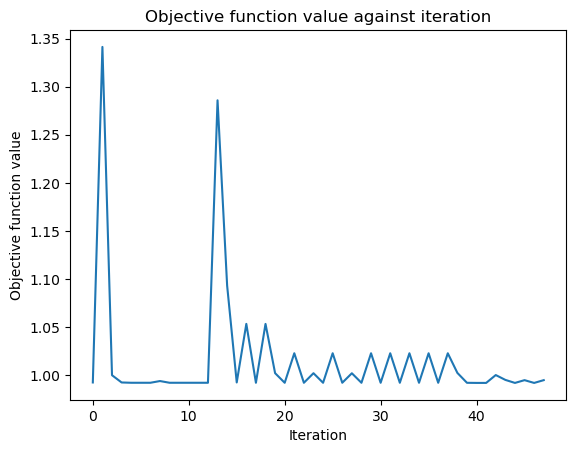

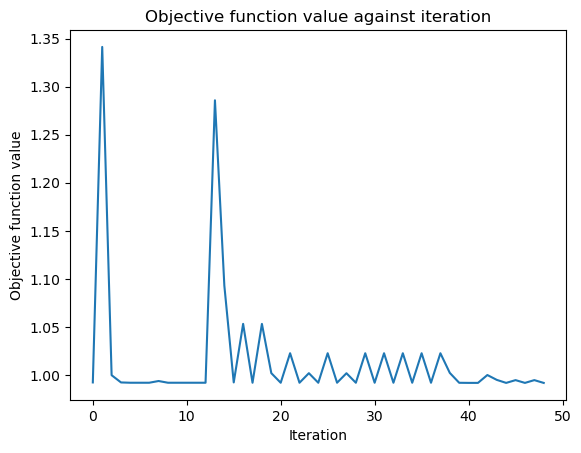

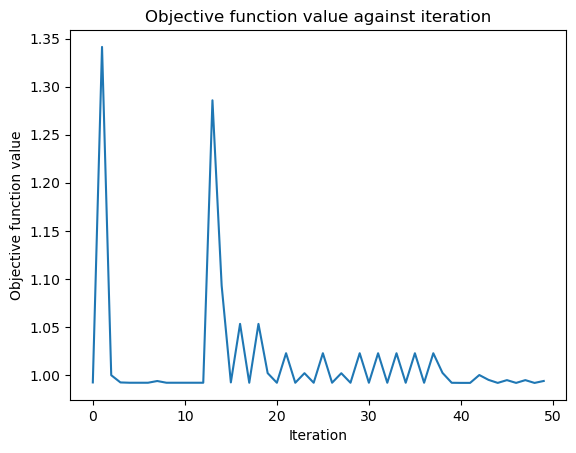

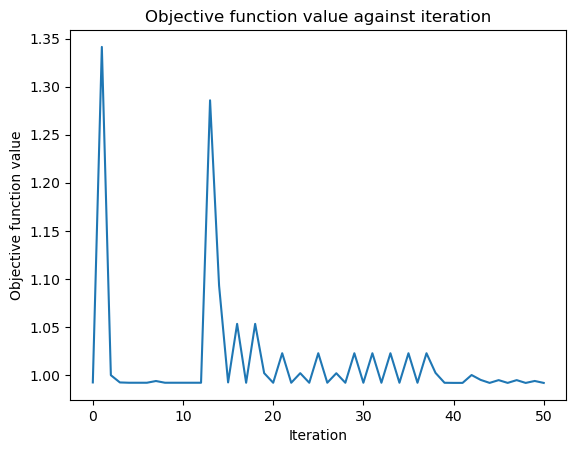

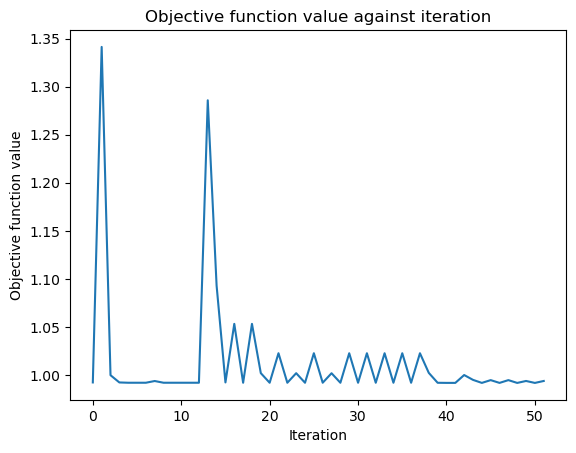

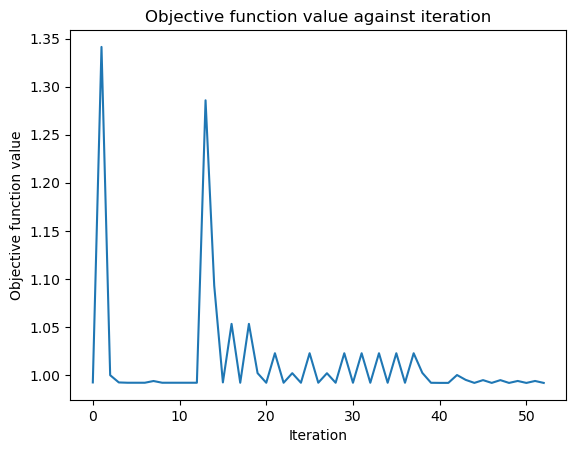

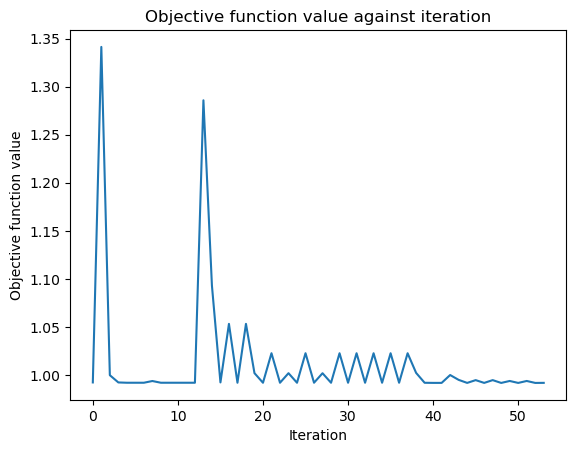

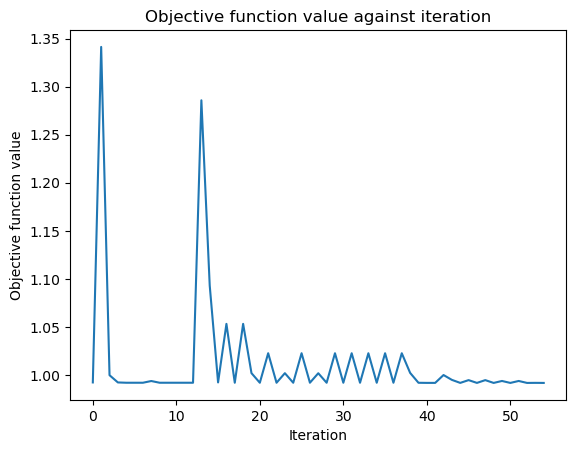

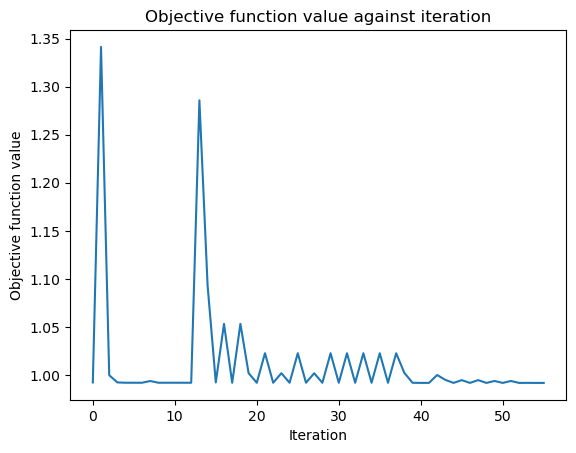

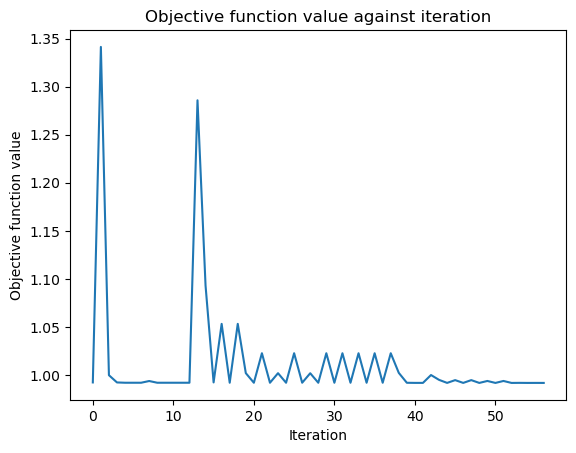

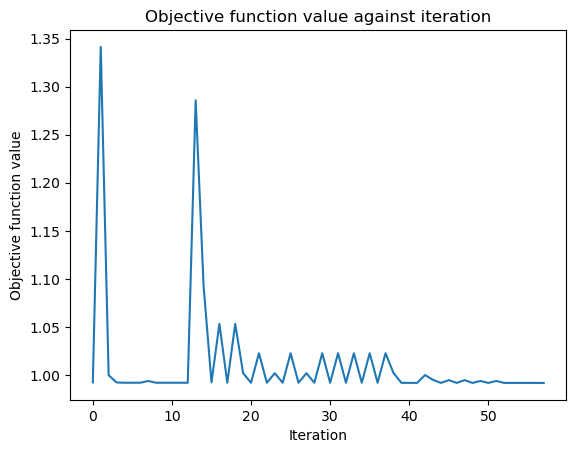

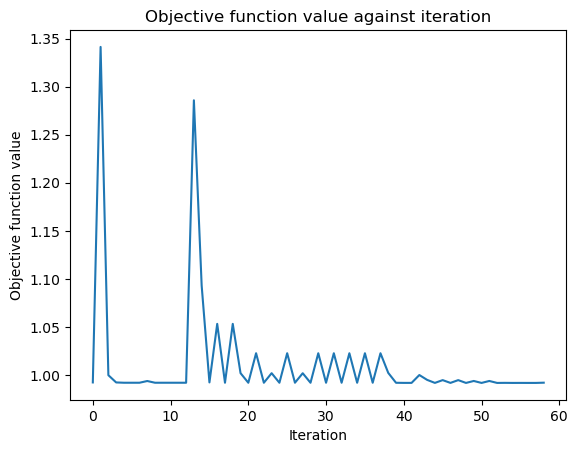

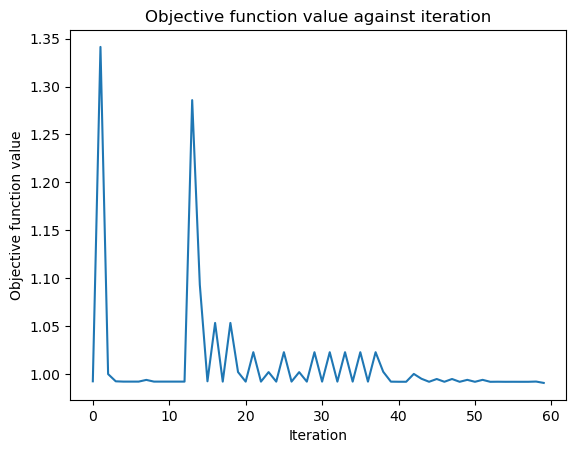

In [7]:

#fit the data to the model
vqc.fit(train_features, train_labels)

#predict test dataset
predicts = vqc.predict(test_features)

In [8]:
x= classification_report(test_labels.astype(float), predicts.astype(float))
print(x)

              precision    recall  f1-score   support

         0.0       0.75      0.63      0.69        19
         1.0       0.30      0.43      0.35         7

    accuracy                           0.58        26
   macro avg       0.53      0.53      0.52        26
weighted avg       0.63      0.58      0.60        26



In [ ]:
#construct ROC Curve
probs = vqc.neural_network.forward(test_features, vqc.weights)


In [ ]:
import math
from sklearn.metrics import roc_curve

b, s, thresholds = roc_curve(test_labels.astype(int), probs[:,0])
def AMS(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )        
    where b_r = 10, b = background, s = signal, log is natural logarithm """
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print ('radicand is negative. Exiting')
        exit()
    else:
        return math.sqrt(radicand)


In [ ]:
FP = 0;
TP = 0;
TN = 0;
FN = 0;
train_predicts = estimator_classifier.predict(train_features.astype(int))

for i in range(len(train_predicts)):
    if(train_predicts[i] == 1):
        if(train_labels[i] == -1):
            FP=FP+1;
    if(train_predicts[i] == train_labels[i]):
        TP=TP+1;
for i in range(len(predicts)):
    if(train_predicts[i] == -1):
        if(train_labels[i] == -1):
            TN=TN+1;
    if(train_predicts[i] == -1):
        if(train_labels[i] == 1):
            FN=FN+1;

     
fpr = FP/(FP+TN)
tpr = TP/(TP+FN)
print('AMS Score:')
AMS(tpr,fpr)

In [ ]:
#fpr, tpr, thresholds = roc_curve(test_labels.astype(float), probs[:,0])

plot = RocCurveDisplay.from_predictions(test_labels.astype(int), probs[:,0])
plt.show()

#score vqc
#x= classification_report(test_labels, vqc.predict(test_features))
#print(x)